# IE 582 Statistical Learning for Data Mining
##### Homework 2
##### Fatih Mehmet Yılmaz - 2024702054

### 1. Introduction

In [6]:
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load the match data
match_data = pd.read_csv("match_data.csv")

#### Calculate Raw Probabilities

To compute the raw probabilities for match outcomes, we use the formula:

$$
P(x) = \frac{1}{\text{odd}}
$$

where:
- $P(x)$ is the probability of the outcome \(x\).
- $\text{odd}$ represents the bookmaker's odds for the corresponding outcome.

##### Calculations:
1. **Home Win**:
   $$
   P(\text{home win}) = \frac{1}{\text{odd_home}}
   $$
   
2. **Draw**:
   $$
   P(\text{draw}) = \frac{1}{\text{odd_draw}}
   $$

3. **Away Win**:
   $$
   P(\text{away win}) = \frac{1}{\text{odd_away}}
   $$

These probabilities provide the implied likelihood of each outcome based on the bookmaker's odds.


### 2. Part-1 Implementation

In [7]:
# Filter out rows where 'suspended' or 'stopped' is True since these rows contain invalid odds.

filtered_data = match_data[(match_data['suspended'] != True) & (match_data['stopped'] != True)]

# Calculate P(home win), P(draw), P(away win)
filtered_data['P_home'] = 1 / filtered_data['1']
filtered_data['P_draw'] = 1 / filtered_data['X']
filtered_data['P_away'] = 1 / filtered_data['2']

#### Normalize Probabilities

After calculating the raw probabilities for match outcomes, we normalize them so that their sum equals 1. This is done using the following formula:

$$
P_{\text{normalized}}(x) = \frac{P(x)}{\sum P(x)}
$$

where:
- $P(x)$ is the raw probability of the outcome \(x\).
- $\sum P(x)\$ is the sum of raw probabilities for all outcomes (Home Win, Draw, and Away Win).

##### Calculations:
1. Compute the sum of raw probabilities:
   $$
   \text{Sum} = P(\text{home win}) + P(\text{draw}) + P(\text{away win})
   $$

2. Normalize each probability:
   - For Home Win:
     $$
     P_{\text{normalized}}(\text{home win}) = \frac{P(\text{home win})}{\text{Sum}}
     $$
   - For Draw:
     $$
     P_{\text{normalized}}(\text{draw}) = \frac{P(\text{draw})}{\text{Sum}}
     $$
   - For Away Win:
     $$
     P_{\text{normalized}}(\text{away win}) = \frac{P(\text{away win})}{\text{Sum}}
     $$

##### Purpose:
Normalization ensures that the probabilities are comparable and add up to 1, reflecting a proper probability distribution.


In [8]:
# Normalize probabilities
prob_sum = filtered_data[['P_home', 'P_draw', 'P_away']].sum(axis=1)
filtered_data['P_home_norm'] = filtered_data['P_home'] / prob_sum
filtered_data['P_draw_norm'] = filtered_data['P_draw'] / prob_sum
filtered_data['P_away_norm'] = filtered_data['P_away'] / prob_sum

#### Calculate Difference Between Probabilities

To analyze the difference in probabilities, we calculate the difference between the probabilities of a home win and an away win for both raw and normalized probabilities.

##### Raw Probability Difference:
The difference in raw probabilities is computed as:
$$
\Delta = P(\text{home win}) - P(\text{away win})
$$

##### Normalized Probability Difference:
The difference in normalized probabilities is computed as:
$$
\Delta_{\text{norm}} = P_{\text{normalized}}(\text{home win}) - P_{\text{normalized}}(\text{away win})
$$

##### Purpose:
1. The raw probability difference $(\Delta)$ provides insight into the bookmakers' unadjusted predictions for home and away wins.
2. The normalized probability difference $(\Delta_{\text{norm}})$ ensures the values are properly scaled and comparable, accounting for normalization effects.

##### Next Step:
The calculated differences $(\Delta)$ and $(\Delta_{\text{norm}})$ will be discretized into bins to perform further analysis.


In [9]:
# Calculate P(home win) - P(away win)
filtered_data['home_minus_away'] = filtered_data['P_home'] - filtered_data['P_away']
filtered_data['home_minus_away_norm'] = filtered_data['P_home_norm'] - filtered_data['P_away_norm']

#### Discretize into Bins

To analyze how the differences between probabilities correspond to match outcomes, we discretize the probability differences into bins.

##### Discretization:
1. **Bins for Raw Differences ($(\Delta)$)**:
   - The raw probability differences ($(\Delta)$) are grouped into equal intervals (bins). For example:
     $$
     (-1, -0.8], (-0.8, -0.6], \ldots, (0.8, 1]
     $$
   - These bins represent ranges of probability differences between home win and away win.

2. **Bins for Normalized Differences ($(\Delta_{\text{norm}})$)**:
   - Similarly, the normalized probability differences ($(\Delta_{\text{norm}})$) are grouped into the same bins for consistency.

##### Assignment:
Each match is assigned to a bin based on:
- The raw probability difference ($(\Delta)$).
- The normalized probability difference ($(\Delta_{\text{norm}})$)).

##### Purpose:
Discretization helps in aggregating matches into groups where differences in probabilities are similar. This enables further analysis, such as calculating empirical probabilities of draws for each bin.


In [10]:
# Bin values
bins = np.linspace(-1, 1, 21)  # Example bins: 20 equal intervals from -1 to 1
filtered_data['bin'] = pd.cut(filtered_data['home_minus_away'], bins)
filtered_data['bin_norm'] = pd.cut(filtered_data['home_minus_away_norm'], bins)

### Step 6: Calculate Empirical Probabilities of Draws

After assigning matches to bins based on probability differences, we calculate the empirical probability of draws for each bin.

#### Steps:
1. **Count Matches in Each Bin**:
   - For each bin:
     - Count the total number of matches assigned to that bin.
     - Count the number of matches that ended as a draw $(\text{result} = X)$.

2. **Calculate Empirical Probability**:
   - The empirical probability of draws for each bin is computed as:
     $$
     P_{\text{empirical}}(\text{draw}) = \frac{\text{Matches Ending in Draw}}{\text{Total Matches in Bin}}
     $$

#### Purpose:
This step helps determine how often matches end in a draw for each range of probability differences. It provides a real-world comparison against the bookmakers' implied probabilities.


In [11]:
# Calculate empirical probabilities
empirical_probs = filtered_data.groupby('bin')['result'].apply(lambda x: (x == 'X').mean())
empirical_probs_norm = filtered_data.groupby('bin_norm')['result'].apply(lambda x: (x == 'X').mean())

#### Visualization

To better understand the relationship between probability differences and match outcomes, we create visualizations.

1. **Plot Variables**:
   - $x$-axis: Probability Difference $(\Delta)$ or Normalized Probability Difference $(\Delta_{\text{norm}})$.
   - $y$-axis: Empirical Probability of Draws $(P_{\text{empirical}}(\text{draw}))$.

2. **Plot Details**:
   - Create two scatter plots:
     1. One for raw probabilities ($(\Delta)$).
     2. One for normalized probabilities ($(\Delta_{\text{norm}})$).

3. **Labels and Titles**:
   - Label the axes:
     - $x$-axis: $(P(\text{home win}) - P(\text{away win}))$
     - $y$-axis: Empirical $(P(\text{draw})$

##### Purpose:
Visualizing the empirical probabilities against probability differences allows us to identify trends and biases in bookmakers' odds for draws.


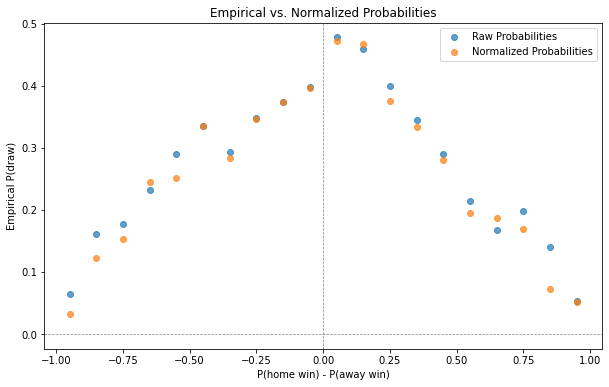

In [12]:
# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(bins[:-1] + 0.05, empirical_probs, label='Raw Probabilities', alpha=0.7)
plt.scatter(bins[:-1] + 0.05, empirical_probs_norm, label='Normalized Probabilities', alpha=0.7)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.7)
plt.xlabel('P(home win) - P(away win)')
plt.ylabel('Empirical P(draw)')
plt.title('Empirical vs. Normalized Probabilities')
plt.legend()
plt.show()

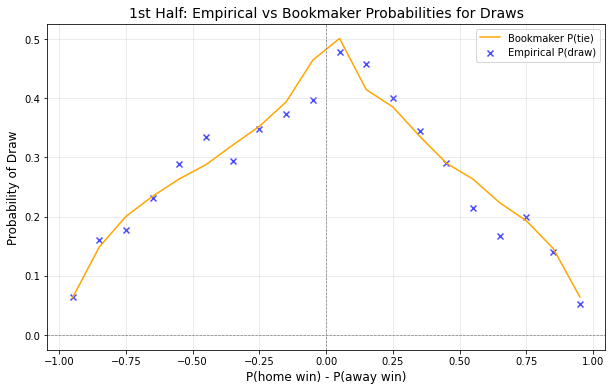

In [14]:
filtered_data['P_tie'] = 1 / filtered_data['X']  # Ensure P_tie is calculated if not present

# Calculate empirical probabilities of draws within each bin
draw_counts = filtered_data[filtered_data['result'] == 'X'].groupby('bin').size()
total_counts = filtered_data.groupby('bin').size()
empirical_draw_probabilities = (draw_counts / total_counts).fillna(0)

# Calculate average bookmaker probabilities of a draw within each bin
average_bookmaker_tie_probabilities = filtered_data.groupby('bin')['P_tie'].mean()

# Midpoints of bins for plotting
bin_midpoints = [(interval.left + interval.right) / 2 for interval in filtered_data['bin'].cat.categories]

# Plotting empirical vs bookmaker probabilities
plt.figure(figsize=(10, 6))

# Scatter plot for empirical probabilities
plt.scatter(bin_midpoints, empirical_draw_probabilities, label='Empirical P(draw)', color='blue', marker='x', alpha=0.7)

# Line plot for bookmaker probabilities
plt.plot(bin_midpoints, average_bookmaker_tie_probabilities, label='Bookmaker P(tie)', color='orange')

# Add horizontal and vertical lines at 0 for reference
plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.7)

# Axis labels and title
plt.xlabel('P(home win) - P(away win)', fontsize=12)
plt.ylabel('Probability of Draw', fontsize=12)
plt.title('1st Half: Empirical vs Bookmaker Probabilities for Draws', fontsize=14)

# Legend and display
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

